# Project Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## Objective

In this notebook, I will perform EDA on the data bike sharing data before forecasting the bike rental demand. The EDA will inform feature selection / engineering to be fed into the models.

# Dependencies

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

# Data Exploration

In [39]:
bike_data = pd.read_csv("../data/train.csv")

Let's take a glimps at the first few records. 

In [40]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [41]:
def data_analysis(df):
    '''
    Takes in a dataframe as input and prints out the Shape, Column Names, Data Types,
    and Null Values
    '''
    print("Data Shape:")
    print(df.shape, end = "\n\n")
    print("Column Names:")
    print(df.columns, end = "\n\n")
    print("Data Types:")
    print(df.dtypes, end = "\n\n")
    print("Null Values:")
    print(df.isnull().sum())


In [42]:
data_analysis(bike_data)

Data Shape:
(10886, 12)

Column Names:
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Data Types:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Null Values:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


Looks like there are no null values and one Object value.

The description of the columns are as follows:

datetime - hourly date + timestamp<br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter<br>
holiday - whether the day is considered a holiday<br>
workingday - whether the day is neither a weekend nor holiday<br>
weather - <br>1: Clear, Few clouds, Partly cloudy<br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius<br>
atemp - "feels like" temperature in Celsius<br>
humidity - relative humidity<br>
windspeed - wind speed<br>
casual - number of non-registered user rentals initiated<br>
registered - number of registered user rentals initiated<br>
count - number of total rentals<br>

Looking at the descriptions above, it may be wise to remove _casual_ and _registered_ from our model as it may introduce leakage

Let's change the datetime column from _object_ to _datetime_

In [43]:
def add_time_date(df):
    """
    Function to add new columns using the datetime column
    """
    new_df = df
    new_df.datetime = df['datetime'].apply(lambda x: 
                                                  datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    new_df['hour'] = df['datetime'].apply(lambda x: x.hour)
    new_df['day'] = df['datetime'].apply(lambda x: x.day)
    new_df['month'] = df['datetime'].apply(lambda x: x.month)
    new_df['year'] = df['datetime'].apply(lambda x: x.year)
    
    return new_df

In [44]:
bike_data = add_time_date(bike_data)

## Univariate Analyses

### Dependent variable

First, let's look at the distribution of the y column, or the dependent variable

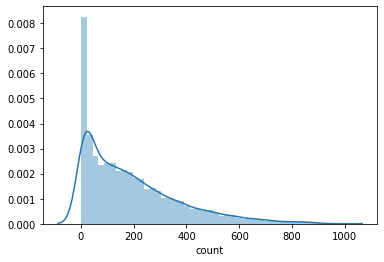

In [45]:
sns.distplot(bike_data['count'])

As you can see, the variable is skewed to the right. If we were to use regression, it may cause a problem because of it's reliance on the normal distribution assumption. Let's try a log transformation to see if it may be better.

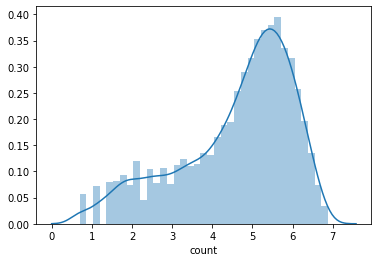

In [46]:
sns.distplot(np.log1p(bike_data['count']))

With them side by side:

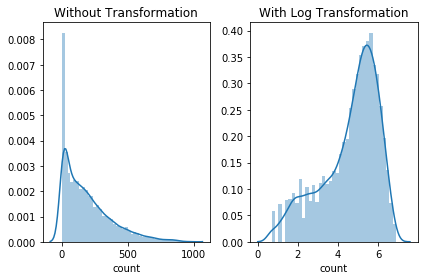

In [47]:
fig, axs = plt.subplots(ncols=2)

sns.distplot(bike_data['count'], ax=axs[0])
sns.distplot(np.log1p(bike_data['count']), ax=axs[1])

axs[0].set_title('Without Transformation')
axs[1].set_title('With Log Transformation')

plt.tight_layout()
plt.savefig('../figs/count_dist.png', bbox_inches='tight', pad_inches=0)


With the transformation, the distribution is more of a bell-curved shape. 

Inferences:
* If we were to use regression, then it'll be helpful to perform a log transformation on the dependent variable (and remember to revert it back when making predictions

### Independent Variables

Looking at the description, the following columns are categorical variables: ['season', 'holiday', 'workingday', 'weather'].

Also, seems like _workday_ / _holidays_ may have some correlation. We'll keep note of that

Let's do a univariate analysis on these variables first

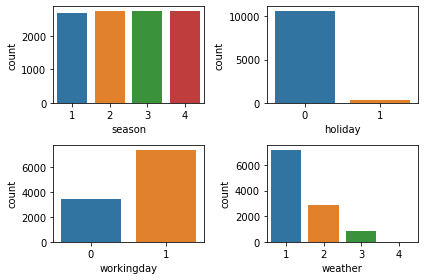

In [48]:
categ_cols = ['season', 'holiday', 'workingday', 'weather']

for counter, col in enumerate(categ_cols, 1):
    plt.subplot(2, 2, counter)
    sns.countplot(col, data = bike_data)
    
plt.tight_layout()

Note that the y axes on the subplots above is for the number of records/instances, not bike demand count

Inferences:
* The records are spread out among the seasons
* Most weathers are clear, few clouds, party cloudy

Next, let's look at the continous variables

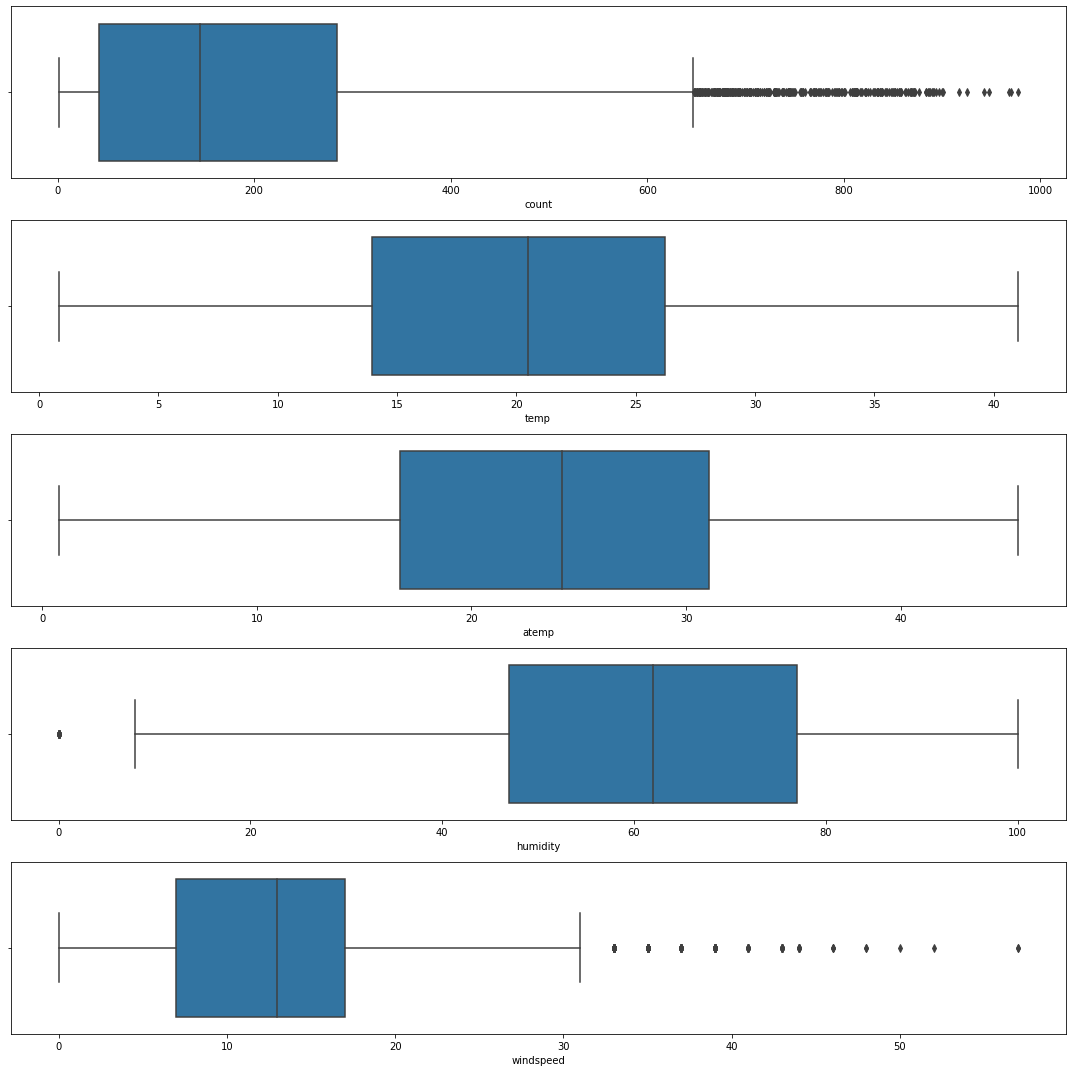

In [49]:
cont_cols = ['count', 'temp', 'atemp', 'humidity', 'windspeed']

fig, axs = plt.subplots(5, figsize = (15, 15))

for counter, col in enumerate(cont_cols):
    sns.boxplot(col, data = bike_data, ax = axs[counter])


plt.tight_layout()

Inferences:
* count have a lot of outliers. May be useful to only look at those within 3 standard deviations
* windspeed has some outliers beyond 30, but not a significant amount

## Correlation Analysis

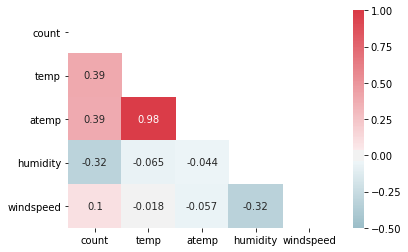

In [50]:
corr = bike_data[cont_cols].corr()
mask = np.triu(np.ones_like(corr, dtype = np.bool))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask = mask, annot = True, cmap = cmap, vmin = -.5, vmax = 1, center = 0)

plt.savefig('../figs/corr_matrix.png', bbox_inches='tight', pad_inches=0)

Looking at the correlation heatmap above:
* atemp and temp are highly correlated, as expected
* atemp and temp are positively correlated with count, and humidity is negatively correlated with count
* windspeed is not really correlated with count

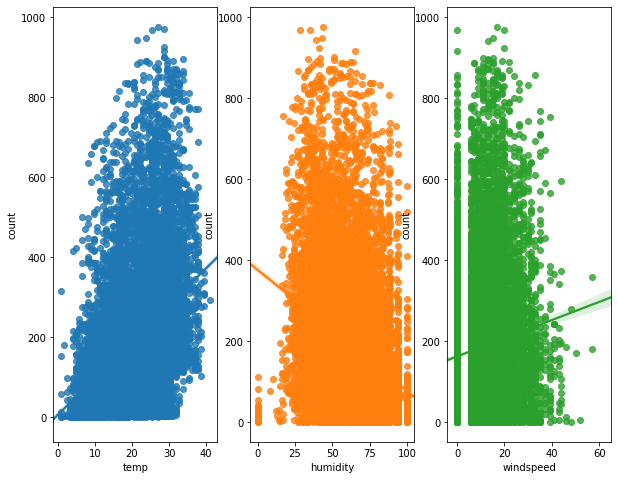

In [51]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 8))

sns.regplot(x = 'temp', y = 'count', data = bike_data, ax = axs[0])
sns.regplot(x = 'humidity', y = 'count', data = bike_data, ax = axs[1])
sns.regplot(x = 'windspeed', y = 'count', data = bike_data, ax = axs[2])


These plots confirm our previous inference points

## Outlier Analysis

Let's look at some additional boxplots showing interactions between categorical variables and the counts column to see where we may see some count outliers.

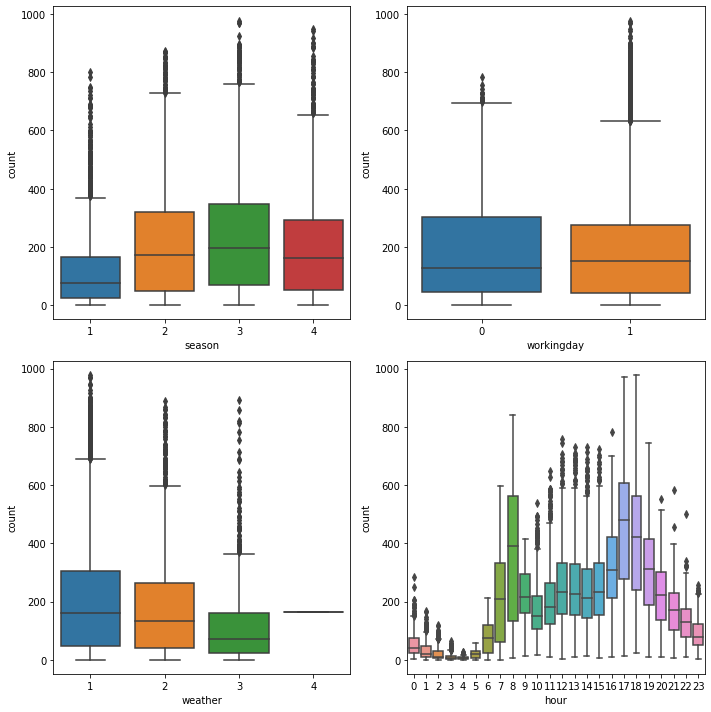

In [52]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

sns.boxplot(x = 'season', y = 'count', data = bike_data, ax = axs[0, 0])
sns.boxplot(x = 'workingday', y = 'count', data = bike_data, ax = axs[0, 1])
sns.boxplot(x = 'weather', y = 'count', data = bike_data, ax = axs[1, 0])
sns.boxplot(x = 'hour', y = 'count', data = bike_data, ax = axs[1, 1])

plt.tight_layout()
plt.savefig('../figs/categ_vars.png', bbox_inches='tight', pad_inches=0)

Inferences:
* Spring has a relatively lower number of count, and a smaller interquartile range. Seems there is just less demand in Spring
* Clear skies, as expected, have the most count
* More demand of bike share around 7am and 5pm 
* workingday has more outliers

When we model, let's remove the count outliers, as they can mess with training the models

# Summary from EDA

* Count has a lot of outliers. So it'll be worth it to remove some
* temp, atemp, and humidity are correlated with count. windspeed not so much
* Only use atemp as temp and atemp are almost the same
* Avoid leakage by excluding registered and casual
